In [1]:
# 기본 패키지 설치
!pip install numpy pandas matplotlib

# nltk
!pip install nltk
# Gensim 및 의존 패키지 설치
!pip install gensim

# spaCy 및 언어 모델 설치
!pip install spacy
!python -m spacy download en_core_web_sm

# 시각화 툴 설치 (pyLDAvis)
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 1.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [20]:
## basic
import re
import numpy as np
import pandas as pd
from pprint import pprint

## nltk
import nltk
nltk.download('stopwords')

## Mallet
# import os 
# from gensim.models.wrappers import LdaMallet

# os.environ['MALLET_HOME'] = '/home/lhshrk/py-TopicModeling/Mallet'

## Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /home/lhshrk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
rawdata = pd.read_csv('/home/lhshrk/bim_gis_integration_LDA_analysis/data/dataset_final_20250224.csv', encoding='utf-8')
documents = pd.DataFrame(rawdata)
documents.head()
len(documents)

409

In [27]:
import re
import numpy as np
import pandas as pd
import nltk
import gensim
import spacy
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from nltk.corpus import stopwords
from pprint import pprint

# nltk 불용어 다운로드
nltk.download('stopwords')

# 텍스트 전처리 (소문자 변환)
documents['whole_lower'] = documents['whole'].str.lower()

data = documents['whole_lower'].dropna().values.tolist()

# 불용어 설정
stop_words = stopwords.words('english')
stop_words.extend(['example', 'research', 'report', 'approach', 'result', 'trend', 'trends', 'from', 'subject', 're', 'edu', 'use', 'early', 'current', 'late', 'korean', 'korea'])

# 텍스트 클리닝
data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data]  # 이메일 제거
data = [re.sub(r'\s+', ' ', sent) for sent in data]  # 공백 정리
data = [re.sub(r"'", "", sent) for sent in data]  # 따옴표 제거

# 토큰화
def sent_to_words(sentences):
    return [simple_preprocess(str(sentence), deacc=True) for sentence in sentences]

data_words = sent_to_words(data)

# Bigram 및 Trigram 모델
bigram = Phrases(data_words, min_count=5, threshold=100)
trigram = Phrases(bigram[data_words], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# 불용어 제거 및 n-gram 적용
def process_words(texts):
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    return texts

data_words_processed = process_words(data_words)

# Lemmatization (표제어 추출)
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

def lemmatization(texts):
    return [[token.lemma_ for token in nlp(' '.join(doc)) if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']] for doc in texts]

data_lemmatized = lemmatization(data_words_processed)

# 결과 확인
pprint(data_lemmatized[:1])


[nltk_data] Downloading package stopwords to /home/lhshrk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[['joint',
  'iso',
  'bim',
  'technical',
  'iso',
  'ogc',
  'buildingsmart',
  'paper',
  'keynote',
  'conference',
  'give',
  'overview',
  'standard',
  'effort',
  'bim',
  'context',
  'motivation',
  'paper',
  'strengthen',
  'general',
  'awareness',
  'promote',
  'technical',
  'iso',
  'tr',
  'iso',
  'tr',
  'academia',
  'professional',
  'engineer',
  'iso',
  'tr',
  'develop',
  'iso',
  'present',
  'discuss',
  'detail',
  'identify',
  'barrier',
  'opportunity',
  'suggest',
  'specific',
  'standard',
  'effort',
  'result',
  'iso',
  'relate',
  'standard',
  'mathematical',
  'foundation',
  'software',
  'product',
  'iso',
  'tr',
  'show',
  'diverse',
  'standard',
  'effort',
  'datum',
  'structure',
  'service',
  'content',
  'process',
  'come',
  'digital_twin',
  'built_environment',
  'conclusion',
  'future',
  'anticipate',
  'need',
  'standard',
  'shortly',
  'present',
  'practical',
  'example']]


Number of Topics: 6, Coherence Score: 0.3162
Number of Topics: 7, Coherence Score: 0.3127
Number of Topics: 8, Coherence Score: 0.3278
Optimal Number of Topics: 8


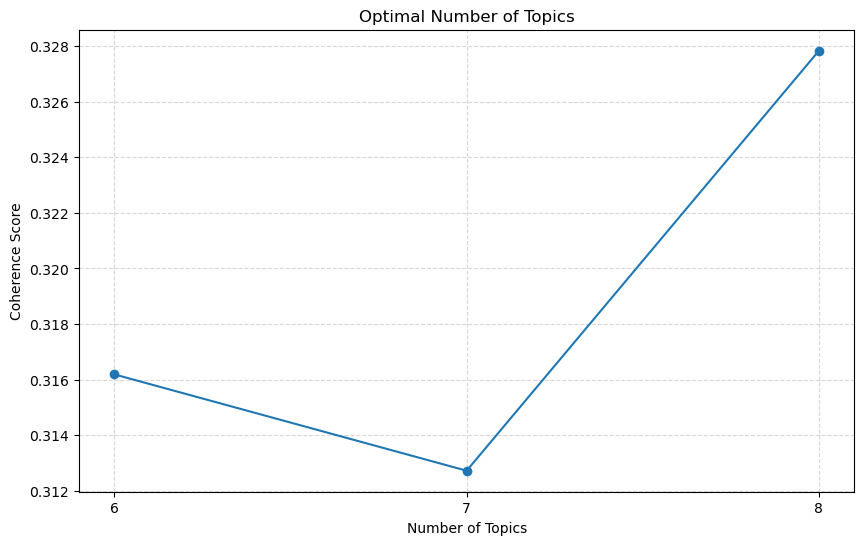

In [28]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel
import matplotlib.pyplot as plt
import gensim.corpora as corpora
import numpy as np
from collections import Counter
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# LDA 수행 전 corpus 및 dictionary 생성
id2word = corpora.Dictionary(data_lemmatized)
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# 최적 토픽 수 선정
min_topics, max_topics = 6, 8
coherence_scores = []

# 우선 괜찮음 topics scope: 2~10까지하면
# for num_topics in range(min_topics, max_topics + 1):
#     model = LdaModel(
#         corpus=corpus, 
#         num_topics=num_topics, 
#         id2word=id2word,
#         random_state=100,
#         chunksize=300,
#         passes=40,
#         iterations=600,
#         alpha='symmetric',
#         eta='auto',
#         minimum_probability=0.05,
#         gamma_threshold=0.01
#         # passes와 iterations를 높히면 중간 값(8)이 올라감
#     )

for num_topics in range(min_topics, max_topics + 1):
    model = LdaModel(
        corpus=corpus, 
        num_topics=num_topics, 
        id2word=id2word,
        random_state=100,
        chunksize=300,
        passes=20,
        iterations=800,
        alpha=0.1,
        eta=0.05,
        minimum_probability=0.05,
        gamma_threshold=0.01
        # passes와 iterations를 높히면 중간 값(8)이 올라감
    )
    coherence_model = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    print(f'Number of Topics: {num_topics}, Coherence Score: {coherence_score:.4f}')

# 최적 토픽 수 결정
optimal_topics = coherence_scores.index(max(coherence_scores)) + min_topics
print(f'Optimal Number of Topics: {optimal_topics}')

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(min_topics, max_topics + 1), coherence_scores, marker='o')
plt.xticks(range(min_topics, max_topics + 1))
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Optimal Number of Topics')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Topic 0:  ['landscape', 'impact', 'study', 'price', 'smart', 'policy', 'use', 'location', 'issue', 'school']
Topic 1:  ['energy', 'model', 'urban', 'building', 'project', 'process', 'system', 'scale', 'information', 'architectural']
Topic 2:  ['bim', 'information', 'datum', 'construction', 'management', 'base', 'study', 'system', 'technology', 'spatial']
Topic 3:  ['indoor', 'model', 'building', 'space', 'spatial', 'navigation', 'standard', 'exist', 'map', 'build']
Topic 4:  ['model', 'datum', 'information', 'bim', 'ifc', 'citygml', 'building', 'semantic', 'use', 'propose']
Topic 5:  ['model', 'building', 'design', 'simulation', 'datum', 'energy', 'network', 'test', 'build', 'control']
Topic 6:  ['city', 'smart', 'technology', 'information', 'model', 'service', 'web', 'datum', 'application', 'various']
Topic 7:  ['system', 'management', 'study', 'base', 'bim', 'method', 'analysis', 'use', 'building', 'safety']


/home/lhshrk/.pyenv/versions/anaconda3-2022.10/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/lhshrk/.pyenv/versions/anaconda3-2022.10/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/lhshrk/.pyenv/versions/anaconda3-2022.10/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/lhshrk/.pyenv/versions/anaconda3-2022.10/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/lhshrk/.pyenv/

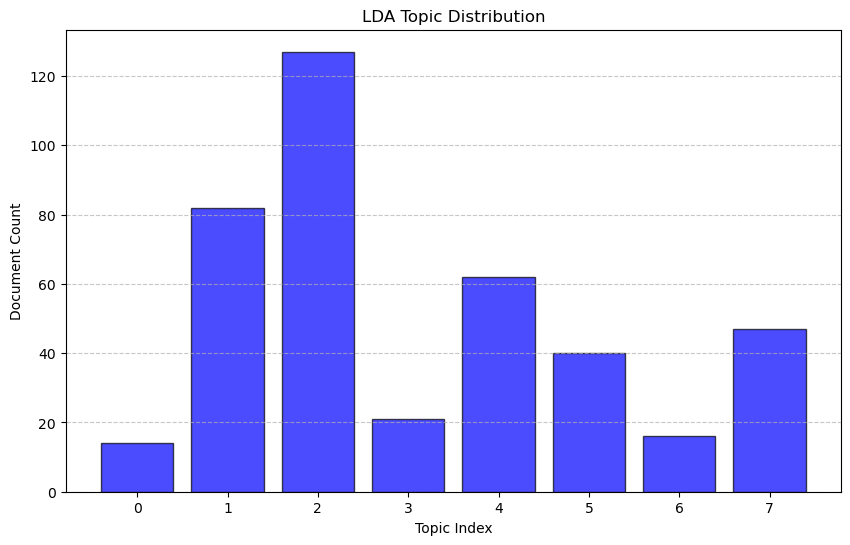

<Figure size 1200x600 with 0 Axes>

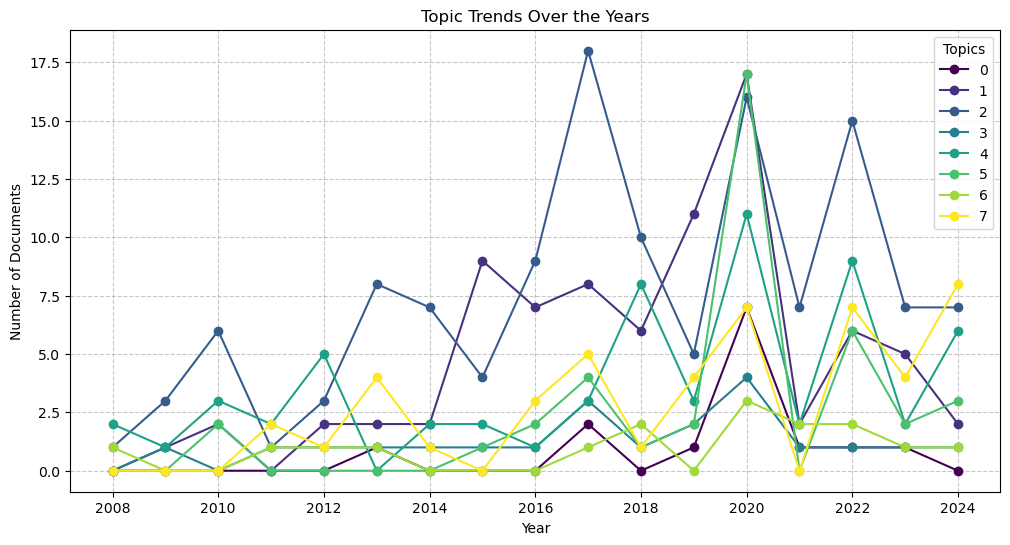


Topic 1: Top 5 Documents
Document ID: 288
Document ID: 271
Document ID: 287
Document ID: 238
Document ID: 105

Topic 2: Top 5 Documents
Document ID: 200
Document ID: 237
Document ID: 139
Document ID: 56
Document ID: 156

Topic 3: Top 5 Documents
Document ID: 134
Document ID: 108
Document ID: 377
Document ID: 332
Document ID: 177

Topic 4: Top 5 Documents
Document ID: 259
Document ID: 279
Document ID: 0
Document ID: 322
Document ID: 202

Topic 5: Top 5 Documents
Document ID: 27
Document ID: 109
Document ID: 91
Document ID: 345
Document ID: 71

Topic 6: Top 5 Documents
Document ID: 251
Document ID: 282
Document ID: 289
Document ID: 276
Document ID: 297

Topic 7: Top 5 Documents
Document ID: 161
Document ID: 51
Document ID: 361
Document ID: 209
Document ID: 69

Topic 8: Top 5 Documents
Document ID: 135
Document ID: 230
Document ID: 260
Document ID: 196
Document ID: 233


<Figure size 1200x600 with 0 Axes>

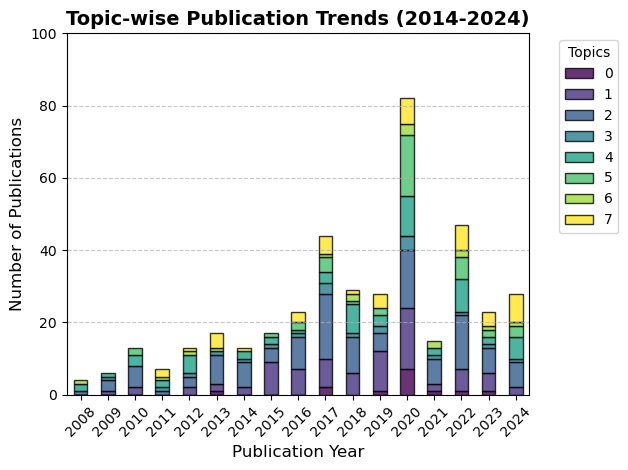

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 최적 토픽을 사용한 LDA 모델 학습
lda_model = LdaModel(
    corpus=corpus, 
    num_topics=optimal_topics, 
    id2word=id2word,
    random_state=100,
    chunksize=300,
    passes=20, #20
    iterations=800,
    alpha=0.1,
    eta=0.05,
    minimum_probability=0.05,
    gamma_threshold=0.01
)

# 토픽별 주요 단어 출력
def show_topics(model, num_words=10):
    topics = model.show_topics(num_topics=optimal_topics, num_words=num_words, formatted=False)
    for topic_id, words in topics:
        print(f"Topic {topic_id}: ", [word[0] for word in words])

show_topics(lda_model)

# 📌 LDA 토픽 시각화
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_vis.html')

vis

# 문서별 주요 토픽 할당
major_topics = [max(lda_model.get_document_topics(doc), key=lambda x: x[1])[0] for doc in corpus]
topic_counts = Counter(major_topics)

# 토픽 분포 시각화
plt.figure(figsize=(10, 6))
plt.bar(topic_counts.keys(), topic_counts.values(), color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Topic Index')
plt.ylabel('Document Count')
plt.title('LDA Topic Distribution')
plt.xticks(range(optimal_topics))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 📌 토픽별 연도에 따른 주요 문서 변화 그래프
document_years = documents['Publication_Year'].tolist()
df_topics = pd.DataFrame({'Year': document_years[:len(major_topics)], 'Topic': major_topics})
df_topic_trends = df_topics.groupby(['Year', 'Topic']).size().unstack().fillna(0)

plt.figure(figsize=(12, 6))
df_topic_trends.plot(kind='line', marker='o', colormap='viridis', figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Number of Documents')
plt.title('Topic Trends Over the Years')
plt.legend(title='Topics')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 토픽별 주요 문서 확인 (IDM 기반)
def get_top_documents_per_topic(model, corpus, num_docs=5):
    topic_docs = {i: [] for i in range(optimal_topics)}
    for doc_id, doc in enumerate(corpus):
        topics = model.get_document_topics(doc)
        dominant_topic = max(topics, key=lambda x: x[1])[0]
        topic_docs[dominant_topic].append((doc_id, topics))
    
    for topic, docs in topic_docs.items():
        print(f"\nTopic {topic}: Top {num_docs} Documents")
        for doc_id, _ in sorted(docs, key=lambda x: -max([t[1] for t in x[1]]))[:num_docs]:
            print(f"Document ID: {doc_id}")

get_top_documents_per_topic(lda_model, corpus)

# 📌 토픽별 논문 건수 변화 그래프 (2014~2024)
plt.figure(figsize=(12, 6))
df_topic_trends.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='black', alpha=0.8)

plt.xlabel("Publication Year", fontsize=12)
plt.ylabel("Number of Publications", fontsize=12)
plt.title("Topic-wise Publication Trends (2014-2024)", fontsize=14, fontweight='bold')

plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [32]:
vis 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.328004 -0.086399       1        1   4.022640
1      0.033122  0.064184       2        1  19.363857
2      0.096672 -0.051609       3        1  25.558638
3     -0.018679  0.130014       4        1   7.320387
4      0.100258  0.031958       5        1  15.678568
5      0.004224  0.169616       6        1  10.336172
6      0.118537 -0.228996       7        1   4.894331
7     -0.006129 -0.028768       8        1  12.825407, topic_info=            Term         Freq        Total Category  logprob  loglift
296         city   279.000000   279.000000  Default  30.0000  30.0000
714       indoor   205.000000   205.000000  Default  29.0000  29.0000
97         model  1063.000000  1063.000000  Default  28.0000  28.0000
326   technology   287.000000   287.000000  Default  27.0000  27.0000
87   information   814.000000   814.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
326   technology    32.718611   287.437289   Topic8  -5.1534  -0.1193
14       develop    30.537641   231.401772   Topic8  -5.2224   0.0285
97         model    35.703081  1063.654216   Topic8  -5.0661  -1.3405
90     integrate    29.009240   240.747221   Topic8  -5.2737  -0.0624
87   information    30.014423   814.268512   Topic8  -5.2396  -1.2469

[581 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
378       3  0.991076         abroad
1194      4  0.865742       absolute
971       5  1.018469       abstract
2355      3  0.911190       academic
2757      3  0.889037  accessibility
...     ...       ...            ...
805       2  0.055291          world
805       3  0.331748          world
805       5  0.082937          world
805       7  0.331748          world
805       8  0.110583          world

[1145 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])